### TA Review 7

#### Tobias

Thank you to Mani and Nick for their previous versions of this material.

#### Forecasting and GMO

#### As seen in August...

(Quantitative) finance can be boiled down to:

$$
p_{t+1} = f(\vec{p}, \mathbf{X})
$$

We want to predict the price (or return) of something at some time in the future ($t+1$), using past prices ($\vec{p}$), and other features ($\mathbf{X}$). Another formulation would be:

$$
p_{t} = e^{-r{n}}\mathbb{E}[p_{t + n}] \rightarrow \tilde{p}_{t} = e^{-rn}f(\vec{p}, \mathbf{X})
$$

That is, the price of any asset *now*, is equal to the discounted expected value of that asset at some point in the future ($t+n$). Some examples of this (and don't worry if you don't know what they mean):

- Option prices: Black-Scholes is *exactly* the discounted expected payoff of an option at expiry (under the risk-neutral measure).
- Bonds: A bond price is equal to the discounted coupon plus principal at maturity.
- M&A Deals, VC, PE: A deal price should be equal to the discounted expected cashflows (DCF model).

So really these are two sides of the same coin: if I have some prediction (expectation) of prices at time $t+n$, I can back-out what the current price should be at time $t$. If there is a discrepancy between my price and what the market price is, I can put on a profitable trade.

#### Anyway, Back to GMO

Some things about forecasting:
- You can't come up with a perfect forecast
- Nor can you truly decompose returns
- There's simply too much noise in the data and outside factors:
    - News, human behavior, etc.
    - Here's a fun one [link](https://x.com/686prism/status/1978186134275469504)
- One typical approach is that you pick what *you* think you're good at, and try to forecast that
- So as a first step you might want to decompose your returns
- And then forecast those individual components
- A podcast [link]( https://www.youtube.com/watch?v=ADfpBrl8Avo)

#### Return Decomposition

The main benefit of this is that it greatly reduces the dimensionality of the problem, in essence you're betting on an "idea" rather than individual assets. So instead of trying to predict each stock, you focus on some set of underlying factors that drive returns.

GMO believes that the returns on a stock would be driven by 4 main factors:

$$
r_i = \text{Div\%} + \%\Delta\text{P/E} + \%\Delta\text{E/S} + \%\Delta\text{S}
$$

Where P/E is the price-to-earnings ratio (ie. price divided by earnings), E/S is earnings per share, and S is the sales per share.

So GMO believes in that in the long run, the drivers of returns are these fundamental factors rather than short-term price movements, ie. "in the short-run the market is a voting machine, but in the long-run it's a weighing machine." 

They were also believers in reversion to this "steady-state" over time. Therefore, they would take long-term views on these stocks and enter/exit trades when the short-term value deviated from them (and held dry-powder accordingly).

What they are principally trying to forecast are these long-term components of returns.

You can immediately see how this is scalable across thousands of stocks, you can easily pull this information from Bloomberg, build a forecast for the components, and then apply it to a huge number of securities.

#### Statistical Decomposition

An alternative approach would be to use statistical methods to come up with factors or features, which need not be interpretable. So even something as simple as linear regression with hand-crafted features can be effective.

$$
r_{i + 1} = \beta \mathbf{X} + \epsilon
$$

These features need not be linear either, you could plug them into a neural network, transformer, or your machine learning model of choice. This is sort of a sliding scale where the least data-driven approach is "financial decomposition" (GMO), a middle-ground is something like a linear model with somewhat interpretable features, and the most data-driven approach would be a deep learning model with many features.

#### Contrarian

GMO is very fundamentally driven. In particular, this means that they tend to be more bearish than other investors when valuations are high, and more bullish when valuations are low. Though, the stock market just keeps going up and so they are typically seen as bears. 

Their very long term (7-10 year) approach means that they are less concerned with short-term market fluctuations, but their investors are. At some point in the 1990s they lost over 60% of their AUM due to withdrawals. Even today, their AUM is down to ~$63Bn from a peak of $155Bn.

#### A Note on Time Horizon

We learned from Barnstable that if our returns have $|\rho| < 1$ autocorrelation, then we benefit from time diversification. That is, as we forecast further into the future, the probability of negative cumulative return decreases. Note, however, that our capital at risk is still increasing (with $\sqrt{t}$!).

The *big* thing here though is that assumes the quality of your forecast over some horizon remains consistent. More specifically, it is much easier to forecast something over a short horizon than a long time horizon, since returns are not i.i.d. For instance, trying to forecast over the next second tends to be easier than over the next year. 

One potentially counter-intuitive thing is that your Sharpe Ratio can actually be higher over shorter hold times than over longer ones. The reason being is that the noise becomes so high at long horizons that it can effectively kill your signal. Additionally, shorter forecasts mean that you can actually make more trades, so you have many more ~i.i.d-ish opportunities to realize PnL compared to buying something and then waiting a month and hoping it goes up.

#### Running the Forecast

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.rcParams["figure.figsize"] = (8, 5)
plt.style.use("bmh")

rets = pd.read_excel(
    "gmo_data.xlsx", sheet_name="total returns", index_col="date", parse_dates=True
)
rfr = (
    pd.read_excel(
        "gmo_data.xlsx", sheet_name="risk-free rate", index_col="date", parse_dates=True
    )
    / 12
)

retsx = rets.subtract(rfr["TBill 3M"], axis=0)

signals = pd.read_excel(
    "gmo_data.xlsx", sheet_name="signals", index_col="date", parse_dates=True
)

We're only going to stick to using the Dividend Yield, so:

$$
r_t \sim \alpha + \beta \text{Div\%}_t + \epsilon
$$

In [ ]:
y = retsx["SPY"]

# Key line to make sure the signal is lagged by one period
x = sm.add_constant(signals["SPX DVD YLD"]).shift(1)

model_dp = sm.OLS(y, x, missing="drop").fit()

model_dp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SPY   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     4.727
Date:                Tue, 11 Nov 2025   Prob (F-statistic):             0.0304
Time:                        23:56:01   Log-Likelihood:                 567.58
No. Observations:                 334   AIC:                            -1131.
Df Residuals:                     332   BIC:                            -1124.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0171      0.011     -1.519      0.130      -0.039       0.005
SPX DVD YLD     0.0132      0.006      2.174      0.030       0.001       0.025
==============================================================================
Omnibus:                       27.416   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.086
Skew:                          -0.627   Prob(JB):                     2.40e-08
Kurtosis:                       3.975   Cond. No.                         11.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looks pretty decent.

In [ ]:
prediction = model_dp.predict(sm.add_constant(signals["SPX DVD YLD"].shift(1)))
weights = 100 * prediction
returns = retsx["SPY"] * weights

pd.DataFrame(
    {
        "Annualized Return": returns.mean() * 12,
        "Annualized Volatility": returns.std() * np.sqrt(12),
        "Annualized Sharpe": returns.mean() / returns.std() * np.sqrt(12),
    },
    index=["Summary"],
).T

,Summary
Annualized Return,0.089093
Annualized Volatility,0.165365
Annualized Sharpe,0.538765


Also pretty good! What is this strategy really doing?

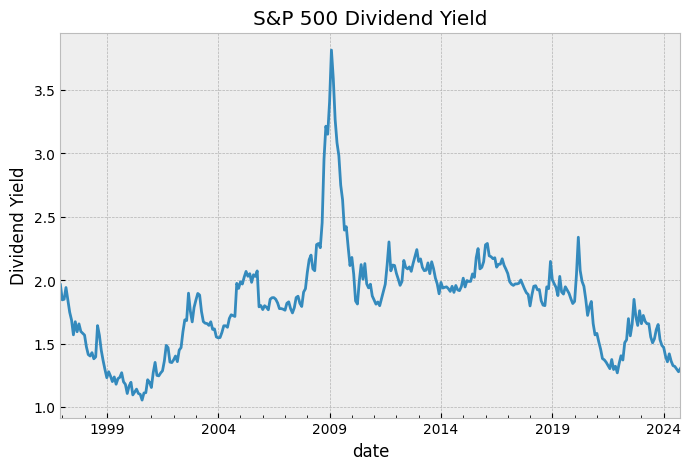

In [ ]:
fig, ax = plt.subplots()

signals["SPX DVD YLD"].plot(ax=ax)
ax.set_title("S&P 500 Dividend Yield")
ax.set_ylabel("Dividend Yield")
plt.show()

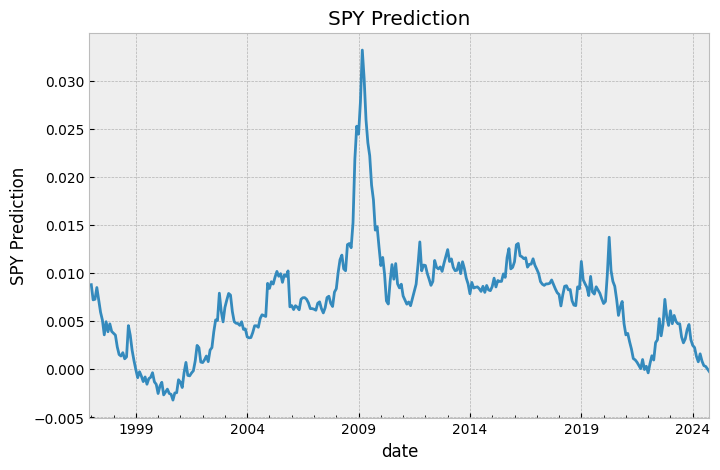

In [ ]:
fig, ax = plt.subplots()

prediction.plot(ax=ax)
ax.set_title("SPY Prediction")
ax.set_ylabel("SPY Prediction")
plt.show()

In [ ]:
negative = (prediction < 0).sum() / len(prediction)
print(f"Percent negative forecast: {negative * 100:.2f}%")

Percent negative forecast: 10.15%


So we're basically always long, our projected SPY return is very rarely less than 0.

In [ ]:
summary = {
    "Beta": [],
    "Alpha (Annualized)": [],
    "Information Ratio (Annualized)": [],
}


X = sm.add_constant(retsx["SPY"])
y = returns
model = sm.OLS(y, X, missing="drop").fit()
summary["Beta"].append(model.params["SPY"])
summary["Alpha (Annualized)"].append(model.params["const"] * 12)
residuals = model.resid
ir = (model.params["const"] * 12) / (residuals.std() * np.sqrt(12))
summary["Information Ratio (Annualized)"].append(ir)

summary_df = pd.DataFrame(
    summary,
    index=["DIV YLD"],
)
summary_df

,Beta,Alpha (Annualized),Information Ratio (Annualized)
DIV YLD,0.787617,0.024719,0.220838


We're basically just long the market, although worth noting that our $\alpha$ is not zero!

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     392.6
Date:                Tue, 11 Nov 2025   Prob (F-statistic):           3.21e-58
Time:                        23:56:01   Log-Likelihood:                 672.96
No. Observations:                 334   AIC:                            -1342.
Df Residuals:                     332   BIC:                            -1334.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.002      1.150      0.251      -0.001       0.006
SPY            0.7876      0.040     19.814      0.000       0.709       0.866
==============================================================================
Omnibus:                      122.537   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4833.678
Skew:                           0.748   Prob(JB):                         0.00
Kurtosis:                      21.577   Cond. No.                         22.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Right...

#### What do we think?

- Our $r^2$ is certainly not 0 on the forecast.
- Can it be less than 0?

.

.

.

.

.

.

.

.

No! It's an in-sample regression with an intercept. That means that no matter what we can't do worse than guessing the mean (what $r^2$ measures).

Why?

$$
R^2 = 1 - \frac{\sum (r_t - \hat{r}_t)^2}{\sum (r_t - \bar{r})^2}
$$

Note that linear regression is literally minimizing the sum of squared residuals (the numerator). So at a minimum, the in-sample $R^2$ cannot be less than zero, because remember that an intercept has the effect of de-meaning the data (so it matches the mean). Therefore, a regression with a non-zero intercept and 0 beta will have an $R^2$ of 0, but we can go no lower.

Can we profit off of it? Also no, our strategy has lookahead bias. The reason is that we are using future information (future shifted divs vs. returns) to inform past trading decisions. In reality, we have no idea what $r_{t+1}$ will be, so we can't use that to inform our model at all.

Therefore, let's run a true predictive OLS, where we use OOS data. The procedure is that we train a model:

$$
r_{t-1} \sim \alpha + \beta \text{Div}_{t-2} + \epsilon
$$

And then we evaluate this model on the out of sample returns, ie.

$$
r_{t} \sim \alpha + \beta \text{Div}_{t-1} + \epsilon
$$

We need a way to measure it, and therefore we use the OOS R-squared:

$$
R^2_{OOS} = 1 - \frac{\sum (r_t - \hat{r}_t)^2}{\sum (r_t - \bar{r})^2}
$$

**NOTE** this is exactly the same formula as the in-sample $R^2$, but note that the sums are over the out-of-sample period, where the predictions *can* be arbitrarily worse than the mean, specifically since the model doesn't "know" what $\bar{r}$ is at time $t$!

In [ ]:
# An OOS forecast...
def oos_forecast(y, X, lookback):
    n = len(y)
    preds = pd.Series(index=np.arange(len(y)), dtype=float)
    for i in range(lookback, n):
        y_train = y.iloc[i - lookback : i]
        X_train = X.iloc[i - lookback : i]
        model = sm.OLS(y_train, sm.add_constant(X_train), missing="drop").fit()
        X_test = [1, X.iloc[i]]
        preds[i] = model.predict([X_test])[0]
    preds.index = y.index
    return preds


pred_oos = oos_forecast(retsx["SPY"], signals["SPX DVD YLD"].shift(1), lookback=60)

idx = pred_oos.dropna().index

# Calculate the OOS r^2
ss_res = np.sum((retsx["SPY"].loc[idx] - pred_oos.loc[idx]) ** 2)
ss_tot = np.sum((retsx["SPY"].loc[idx] - np.mean(retsx["SPY"].loc[idx])) ** 2)
r2_oos = 1 - ss_res / ss_tot

print(f"OOS R^2: {r2_oos:.4f}")

OOS R^2: -0.0824


Note that even this mildly has lookahead bias! Can you spot it?

.

.

.

.

.

.

.

We're again using the full sample mean. If we want a more "accurate" $R^2$, we should use an expanding mean up until the point where we make the forecast. That is, it is perhaps a little unfair to the model to use future data to evaluate current forecasts.

In [ ]:
pred_benchmark = retsx["SPY"].expanding(min_periods=60).mean()

results = pd.DataFrame(
    {"actual": retsx["SPY"], "model_pred": pred_oos, "benchmark_pred": pred_benchmark}
)

results_oos = results.dropna()

ss_res = np.sum((results_oos["actual"] - results_oos["model_pred"]) ** 2)
ss_tot = np.sum((results_oos["actual"] - results_oos["benchmark_pred"]) ** 2)

r2_oos = 1 - (ss_res / ss_tot)

print(f"OOS R^2: {r2_oos}")

OOS R^2: -0.08858602450489639


Does it make sense to think about OOS $R^2$ as a measure of model performance?

In [ ]:
weights_oos = 100 * pred_oos.loc[idx]
returns_oos = retsx["SPY"].loc[idx] * weights_oos.loc[idx]
pd.DataFrame(
    {
        "Annualized Mean": returns_oos.mean() * 12,
        "Annualized Volatility": returns_oos.std() * np.sqrt(12),
        "Annualized Sharpe": returns_oos.mean() / returns_oos.std() * np.sqrt(12),
    },
    index=["Summary"],
).T

,Summary
Annualized Mean,0.075904
Annualized Volatility,0.337267
Annualized Sharpe,0.225057


This still has positive Sharpe.

In [ ]:
model_mkt = sm.OLS(
    returns_oos.loc[idx], sm.add_constant(retsx["SPY"].loc[idx]), missing="drop"
).fit()

information_ratio = model_mkt.params["const"]
beta = model_mkt.params["SPY"]
alpha_annualized = model_mkt.params["const"] * 12
residuals = model_mkt.resid
ir = alpha_annualized / (residuals.std() * np.sqrt(12))

print(f"Information Ratio: {ir:.2f}\nAlpha: {alpha_annualized:.2%}\nBeta: {beta:.2f}")

Information Ratio: 0.23
Alpha: 7.83%
Beta: -0.03


And a positive alpha?

The key thing to note here is that OOS $R^2$ heavily penalizes *magnitude*, and much less so direction. That is, suppose that your model perfectly predicts when SPY is going to go up or down, but is always off by a factor of 10.

Then our OOS $R^2$ is going to be:

$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$$

Which if we're exactly 10x will be:

$$
R^2 = 1 - \frac{\sum (-9y_i^2)}{\sum (y_i - \bar{y})^2}
$$
$$
R^2 = 1 - \frac{81\sum y_i^2}{\sum (y_i - \bar{y})^2}
$$
Which is obviously going to be way less than 0.

Similarly, we could imagine a case where we might be more wrong on direction, but more right on magnitude. This would potentially even have a positive OOS $R^2$, even though it seems like the first model is WAY better.

Ultimately, the backtest is what matters.

#### Machine Learning

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor


def oos_forecast_nn(y, X, lookback):
    n = len(y)
    preds_array = np.full(n, np.nan)

    for i in range(lookback, n):
        y_train_raw = y[i - lookback : i].reshape(-1, 1)
        X_train_raw = X[i - lookback : i]

        X_test_raw = X[i : i + 1]

        x_scaler = StandardScaler()
        y_scaler = StandardScaler()

        X_train_scaled = x_scaler.fit_transform(X_train_raw)
        y_train_scaled = y_scaler.fit_transform(y_train_raw).ravel()

        X_test_scaled = x_scaler.transform(X_test_raw)

        model = MLPRegressor(hidden_layer_sizes=(500,), max_iter=5_000, random_state=0)
        model.fit(X_train_scaled, y_train_scaled)

        pred_scaled = model.predict(X_test_scaled)
        pred_unscaled = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1))

        preds_array[i] = pred_unscaled[0, 0]

    preds_series = pd.Series(preds_array, index=np.arange(n), dtype=float)
    return preds_series


preds_oos = oos_forecast_nn(
    retsx["SPY"]
    .values[1:]
    .reshape(
        -1,
    ),
    signals["SPX DVD YLD"].shift(1).dropna().values.reshape(-1, 1),
    lookback=60,
)
preds_oos.index = retsx["SPY"].index[1:]
preds = preds_oos.dropna()
idx_oos = preds.index

In [ ]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_data = signals["SPX DVD YLD"].shift(1).dropna().values.reshape(-1, 1)
y_data = retsx["SPY"].values[1:].reshape(-1, 1)

X_scaled = x_scaler.fit_transform(X_data)
y_scaled = y_scaler.fit_transform(y_data).ravel()

model_is = MLPRegressor(hidden_layer_sizes=(500,), max_iter=5000)
model_is.fit(X_scaled, y_scaled)

preds_is_scaled = model_is.predict(X_scaled)
preds_is = y_scaler.inverse_transform(preds_is_scaled.reshape(-1, 1))
preds_is = pd.Series(
    preds_is.ravel(), index=signals["SPX DVD YLD"].shift(1).dropna().index
)

r2_is = 1 - (np.sum((retsx["SPY"].loc[idx_oos] - preds_is.loc[idx_oos]) ** 2)) / np.sum(
    (retsx["SPY"].loc[idx_oos] - np.mean(retsx["SPY"].loc[idx_oos])) ** 2
)

print(f"In-Sample R^2: {r2_is:.4f}")

In-Sample R^2: 0.0123


In [ ]:
r2_oos = 1 - (np.sum((retsx["SPY"].loc[idx_oos] - preds.loc[idx_oos]) ** 2)) / np.sum(
    (retsx["SPY"].loc[idx_oos] - np.mean(retsx["SPY"].loc[idx_oos])) ** 2
)
print(f"Out-of-Sample R^2: {r2_oos:.4f}")

Out-of-Sample R^2: -0.5645


Again, though, what about the PnL?

In [ ]:
rets_oos = retsx.loc[idx_oos, "SPY"] * preds.loc[idx_oos] * 100
rets_is = retsx.loc[idx_oos, "SPY"] * preds_is.loc[idx_oos] * 100

# Calculate Sharpes, etc.
pd.DataFrame(
    {
        "Annualized Mean": [rets_oos.mean() * 12, rets_is.mean() * 12],
        "Annualized Volatility": [
            rets_oos.std() * np.sqrt(12),
            rets_is.std() * np.sqrt(12),
        ],
        "Annualized Sharpe Ratio": [
            rets_oos.mean() / rets_oos.std() * np.sqrt(12),
            rets_is.mean() / rets_is.std() * np.sqrt(12),
        ],
        "R^2": [r2_oos, r2_is],
    },
    index=["Out-of-Sample", "In-Sample"],
)

,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio,R^2
Out-of-Sample,0.132261,0.776456,0.170340,-0.564452
In-Sample,0.096887,0.155986,0.621125,0.012313


In [ ]:
# And market stats.
model_oos = sm.OLS(
    rets_oos.loc[idx_oos], sm.add_constant(retsx["SPY"].loc[idx_oos]), missing="drop"
).fit()

information_ratio = model_oos.params["const"]
beta = model_oos.params["SPY"]
alpha_annualized = model_oos.params["const"] * 12
residuals = model_oos.resid
ir = alpha_annualized / (residuals.std() * np.sqrt(12))

print(f"Information Ratio: {ir:.2f}\nAlpha: {alpha_annualized:.2%}\nBeta: {beta:.2f}")

Information Ratio: 0.21
Alpha: 16.53%
Beta: -0.39


In [ ]:
# And market stats.
model_is = sm.OLS(
    rets_is.loc[idx_oos], sm.add_constant(retsx["SPY"].loc[idx_oos]), missing="drop"
).fit()

information_ratio = model_is.params["const"]
beta = model_is.params["SPY"]
alpha_annualized = model_is.params["const"] * 12
residuals = model_is.resid
ir = alpha_annualized / (residuals.std() * np.sqrt(12))

print(f"Information Ratio: {ir:.2f}\nAlpha: {alpha_annualized:.2%}\nBeta: {beta:.2f}")

Information Ratio: 0.25
Alpha: 1.62%
Beta: 0.95
